Deleting existing folder: /content/Dataset
Extracting dataset...
Total images found: 3067


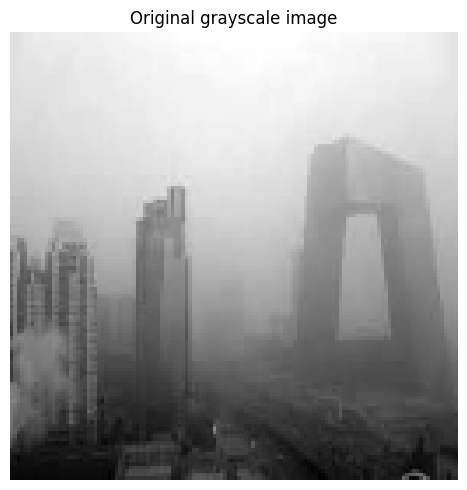

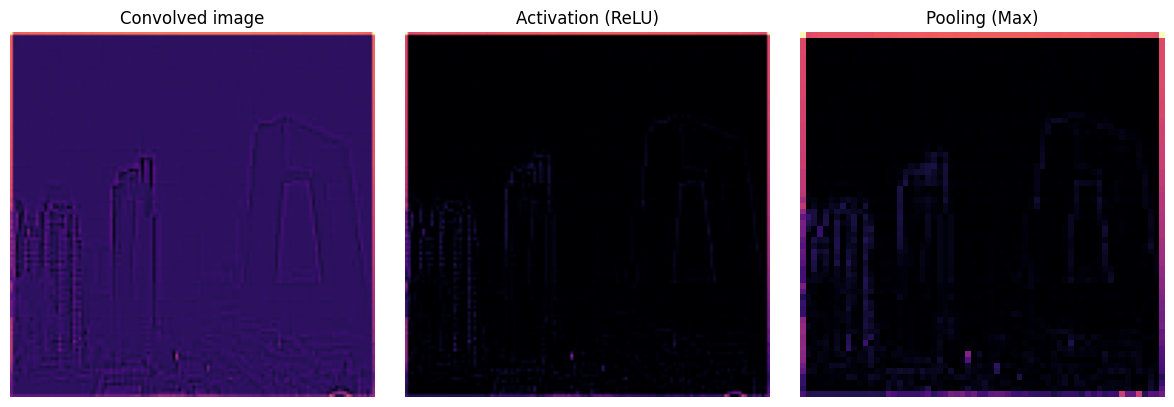

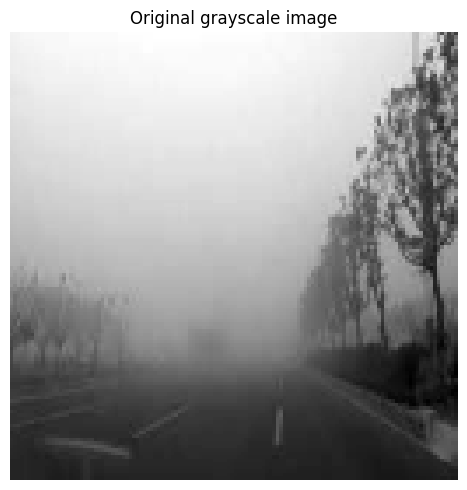

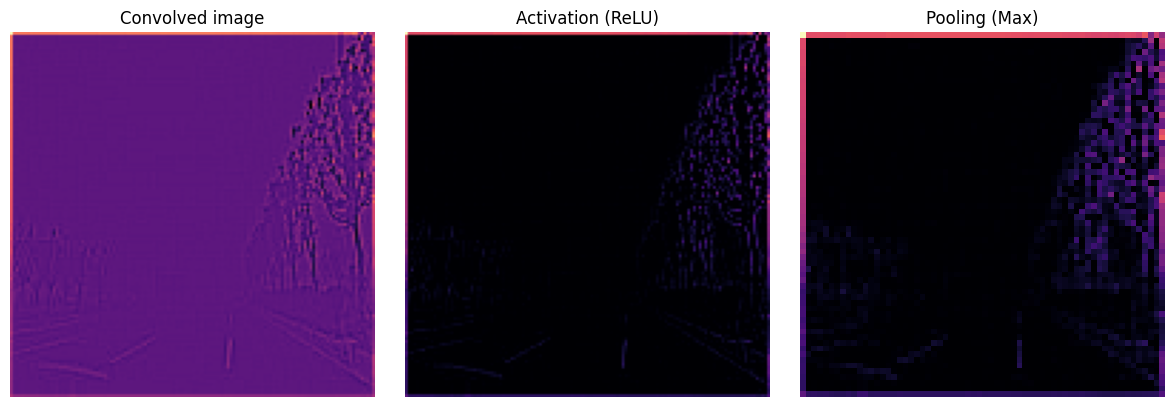

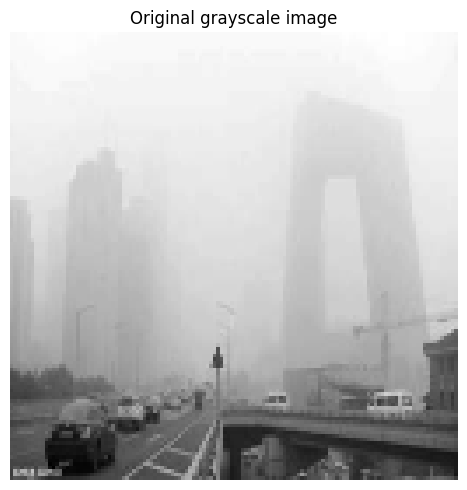

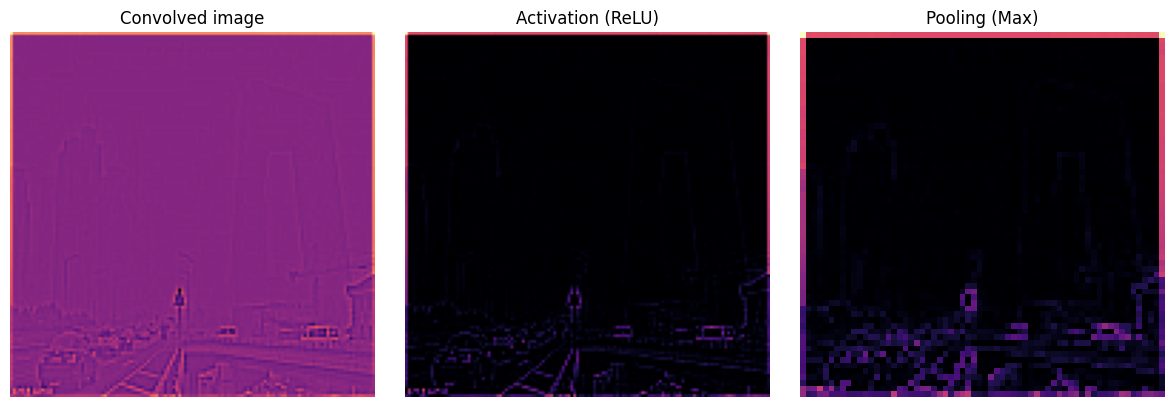

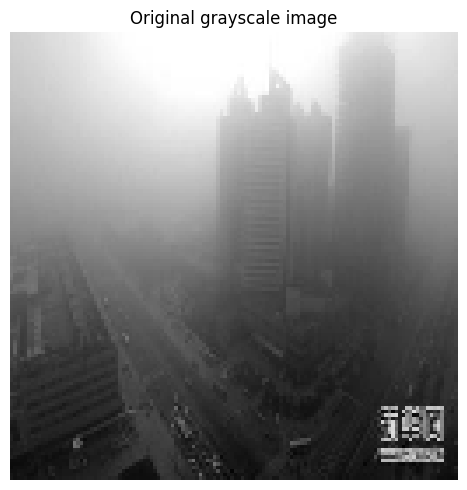

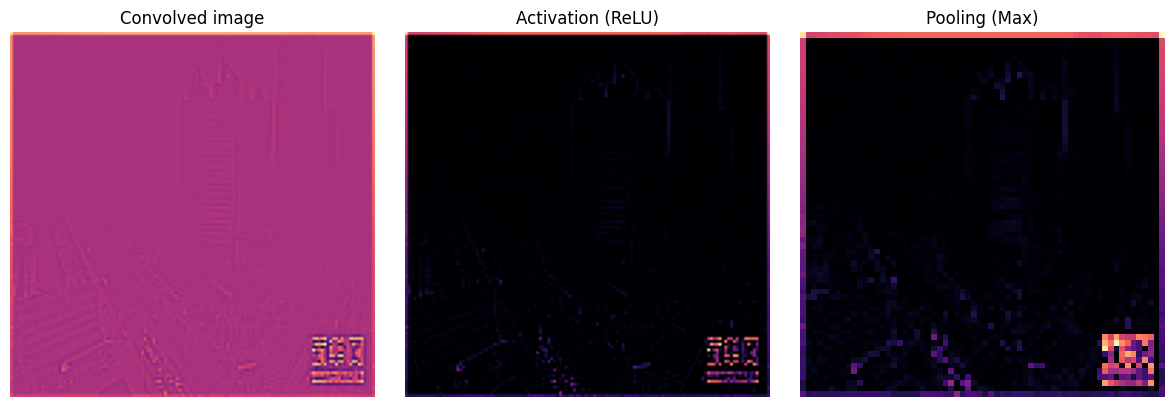

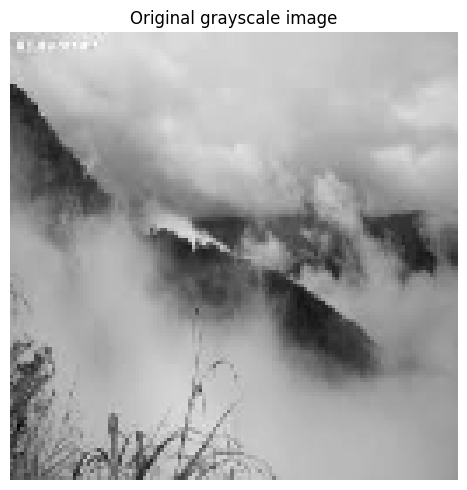

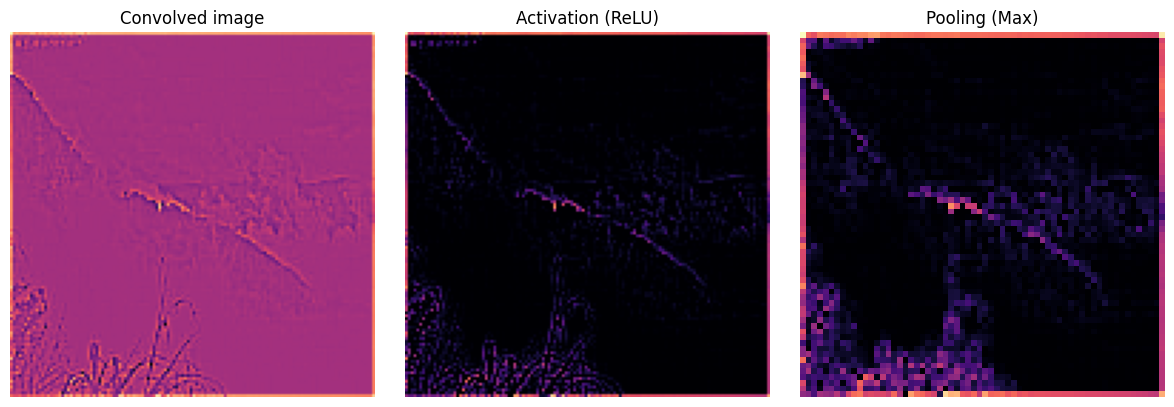

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import glob
import os
import shutil

plt.rc('figure', autolayout=True)
plt.rc('image', cmap='magma')

# Define edge detection kernel
kernel = tf.constant([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]])
kernel = tf.reshape(kernel, [3, 3, 1, 1])
kernel = tf.cast(kernel, tf.float32)

# Paths
zip_path = '/content/reduced_dataset_zipfile.zip'
extract_path = '/content/Dataset'

# Delete existing extraction folder if it exists
if os.path.exists(extract_path):
    print(f"Deleting existing folder: {extract_path}")
    shutil.rmtree(extract_path)

# Extract dataset ZIP
print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Get all image paths (.jpg and .png)
image_paths = glob.glob(os.path.join(extract_path, '**/*.jpg'), recursive=True) + \
              glob.glob(os.path.join(extract_path, '**/*.png'), recursive=True)
print(f"Total images found: {len(image_paths)}")

# Visualize first 5 images
for img_path in image_paths[:5]:
    # Read and decode image as grayscale (channels=1)
    image = tf.io.read_file(img_path)

    # Use decode_jpeg or decode_png depending on extension
    ext = os.path.splitext(img_path)[1].lower()
    if ext == '.jpg' or ext == '.jpeg':
        image = tf.io.decode_jpeg(image, channels=1)
    elif ext == '.png':
        image = tf.io.decode_png(image, channels=1)
    else:
        print(f"Unsupported file type: {img_path}")
        continue

    # Resize image
    image = tf.image.resize(image, [128, 128])

    # Display original grayscale image
    plt.figure(figsize=(5, 5))
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.axis('off')
    plt.title('Original grayscale image')
    plt.show()

    # Convert to float32 and add batch dimension
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.expand_dims(image, 0)

    # Apply convolution
    image_filter = tf.nn.conv2d(image, filters=kernel, strides=1, padding='SAME')
    # Activation (ReLU)
    image_detect = tf.nn.relu(image_filter)
    # Max pooling
    image_condense = tf.nn.pool(image_detect,
                                window_shape=(2, 2),
                                pooling_type='MAX',
                                strides=(2, 2),
                                padding='SAME')

    # Plot all stages
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(tf.squeeze(image_filter), cmap='magma')
    plt.axis('off')
    plt.title('Convolved image')

    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(image_detect), cmap='magma')
    plt.axis('off')
    plt.title('Activation (ReLU)')

    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(image_condense), cmap='magma')
    plt.axis('off')
    plt.title('Pooling (Max)')

    plt.show()


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from zipfile import ZipFile

# Step 1: Upload and Extract Zip
data_path = '/content/reduced_dataset_zipfile.zip'

with ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall()
    print('The dataset has been extracted.')

# Step 2: Set image size and paths
IMG_SIZE = 256
BATCH_SIZE = 32
DATASET_PATH = '/content/Atmospheric_condition'

# Step 3: Simple image loader without augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Step 4: CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Show model summary
model.summary()

# Step 7: Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 8: Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)

# Step 9: Save the model
model.save("weather_classification_model.h5")
print("Model saved as weather_classification_model.h5")


The dataset has been extracted.
Found 2455 images belonging to 5 classes.
Found 612 images belonging to 5 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,621 (56.61 MB)

 Trainable params: 14,839,621 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.5061 - loss: 1.3826 - val_accuracy: 0.7810 - val_loss: 0.6447
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.7539 - loss: 0.6790 - val_accuracy: 0.8056 - val_loss: 0.5724
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.7775 - loss: 0.5775 - val_accuracy: 0.8219 - val_loss: 0.5488
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.8229 - loss: 0.5017 - val_accuracy: 0.8284 - val_loss: 0.5118
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.8560 - loss: 0.4011 - val_accuracy: 0.8219 - val_loss: 0.5113
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.8585 - loss: 0.3833 - val_accuracy: 0.8301 - val_loss: 0.5002
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.8890 - loss: 0.3019 - val_accuracy: 0.8235 - val_loss: 0.5541
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9264 - loss: 0.2254 - val_accu

Model saved as weather_classification_model.h5


In [ ]:
# Save the model
model.save("weather_classification_model.h5")

In [ ]:
from google.colab import files
files.download('weather_classification_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import cv2
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("weather_classification_model.h5")

# Define correct class order based on your training
classes = ['fogsmog', 'lightning', 'rain' , 'sandstorm' , 'snow']

# Test image path
image_path = "/content/fogsmoke_images.jpg"  # CHANGE THIS for each test

# Preprocess the image
IMG_SIZE = 256
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img / 255.0  # Only if you used rescale=1./255 during training
img = np.expand_dims(img, axis=0)

# Predict
predictions = model.predict(img)
print("Raw prediction scores:", predictions)
print("Predicted class:", classes[np.argmax(predictions)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Raw prediction scores: [[9.5751798e-01 2.0938959e-04 1.2341463e-03 3.2368667e-02 8.6698448e-03]]
Predicted class: fogsmog
